# Validation of the identified sites

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 1. Loading in predictions

In [ ]:
ST_set = pd.read_csv("/home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_2,7,30_Preds.csv") 
Y_set = pd.read_csv("/home/sander/apps/slim/ptm_predictions/Y_Phospho_Human_Peptides_2,7,30_Preds.csv")

In [ ]:
# Concatenate the two DataFrames vertically
combined_df = pd.concat([ST_set, Y_set], axis=0, ignore_index=True)
# Sort the combined DataFrame by protein ID and position
combined_df = combined_df.sort_values(['prot_id', 'position'])
# Reset the index after sorting
combined_df = combined_df.reset_index(drop=True)

In [ ]:
combined_df.head()

,prot_id,position,pred
0,A0A024R1R8,2,0.5218
1,A0A024R1R8,3,0.5335
2,A0A024R1R8,55,0.7344
3,A0A024R1R8,61,0.6909
4,A0A024RBG1,9,0.0712


## 2. Results to Sites

### 2.1 Load Runs of One Platform

In [ ]:
"""
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_010_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_040_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_099_speclib.parquet"
"""

In [ ]:
"""
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_000_speclib.parquet",
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_005_speclib.parquet",
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_010_speclib.parquet",
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_020_speclib.parquet",
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_040_speclib.parquet",
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_080_speclib.parquet",
"/public/compomics/sander/regular/TTOF6600_SWATH/diann_results/TTOF6600_SWATH_099_speclib.parquet"
"""

In [ ]:
run_paths = [
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_010_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_040_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet",
"/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_099_speclib.parquet"
]

### 2.2 translate into sites

#### Get Peptides for reference: 

In [ ]:
def read_proteome(canonical_proteome):
    """
    Reads the proteome sequences from the FASTA file, filters X and U aa from proteome

    Parameters:
    canonical_proteome : str
        Path to the FASTA file containing the proteome sequences

    Returns:
    dict
        A dictionary where keys are protein IDs and values are sequences
        {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    """
    sequences = {}  # {prot_id: sequence}
    with open(canonical_proteome, 'r') as f:
        prot_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if prot_id:
                    sequence = ''.join(seq_lines)
                    if 'U' not in sequence and 'X' not in sequence:
                        sequences[prot_id] = sequence
                    seq_lines = []
                prot_id = line[1:].split()[0]
            else:
                seq_lines.append(line)
        if prot_id:
            sequence = ''.join(seq_lines)
            if 'U' not in sequence and 'X' not in sequence:
                sequences[prot_id] = sequence
    return sequences

canonical_proteome = '/home/sander/apps/slim/general_data/UP000005640_9606_prot_id.fasta'
proteome = read_proteome(canonical_proteome)

def digest_protein(sequence, missed_cleavages=0, min_length=0, max_length=None):
    """
    Performs trypsin digestion on a single protein sequence.

    Args:
        sequence (str): Protein sequence
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length (None for no limit)

    Returns:
        list: List of tuples (peptide, start_pos) where start_pos is 0-based

    Example:
        Input: "PEPTIDERPRRPEPTIDE"
        Output: [('PEPTIDER', 0), ('PEPTIDERR', 0), ..., ('RPEPTIDE', 9)]
    """
    cleavage_sites = []
    for i in range(len(sequence) - 1):
        if sequence[i] in ('K', 'R'): # and sequence[i+1] != 'P':
            cleavage_sites.append(i+1)
    cleavage_sites = [0] + cleavage_sites + [len(sequence)]
    
    peptides = []
    for start_idx in range(len(cleavage_sites)-1):
        for end_idx in range(start_idx+1, min(len(cleavage_sites), start_idx+missed_cleavages+2)):
            pep_start = cleavage_sites[start_idx]
            pep_end = cleavage_sites[end_idx]
            peptide = sequence[pep_start:pep_end]
            if min_length <= len(peptide) <= (max_length if max_length else len(peptide)):
                # Validate that the peptide actually starts at pep_start
                assert sequence[pep_start:pep_start+len(peptide)] == peptide
                peptides.append((peptide, pep_start))
    return peptides

def calculate_miscleavages(peptide_seq, protein_seq, start_pos):
    """
    Calculates the number of missed cleavages in a single peptide.

    Args:
        peptide_seq (str): Peptide sequence
        protein_seq (str): Full protein sequence
        start_pos (int): Start position of peptide in protein (0-based)

    Returns:
        int: Number of missed cleavages

    Example:
        Input: ('PEPTIDERPR', 'PEPTIDERPRRPEPTIDE', 0)
        Output: 1
    """
    # Validate that the peptide actually occurs at start_pos
    assert protein_seq[start_pos:start_pos+len(peptide_seq)] == peptide_seq, \
           f"Peptide {peptide_seq} not found at position {start_pos} in protein"
    
    miscleavages = 0
    for i in range(len(peptide_seq)-1):  # Changed range to avoid going past peptide end
        abs_pos = start_pos + i  # Removed the -1 offset
        if protein_seq[abs_pos] in ('K', 'R'):
            miscleavages += 1
    return miscleavages

def trypsin_digest(sequences, missed_cleavages, min_length, max_length):
    """
    Performs trypsin digestion on all protein sequences.
    
    Args:
        sequences (dict): Dictionary of protein sequences {prot_id: sequence}
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length

    Returns:
        list: List of dictionaries containing peptide information
        
    Example:
        Input: {'prot1': 'PEPTIDERRRPEPTIDE...', ...}
        Output: [{'prot_id': 'prot1', 'sequence': 'PEPTIDERPR', 'miscleavages': 1, 
                 'peptide_length': 10, 'start_pos': 0}, ...]
    """
    digested_peptides = []
    for prot_id, seq in sequences.items():
        peptides = digest_protein(seq, missed_cleavages, min_length, max_length)
        for peptide, start_pos in peptides:
            # Validate peptide position
            assert seq[start_pos:start_pos+len(peptide)] == peptide, \
                   f"Position mismatch for peptide {peptide} in protein {prot_id}"
            
            miscleavages = calculate_miscleavages(peptide, seq, start_pos)
            digested_peptides.append({
                'prot_id': prot_id,
                'sequence': peptide,
                'miscleavages': miscleavages,
                'peptide_length': len(peptide),
                'start_pos': start_pos
            })
    return digested_peptides

peptides = trypsin_digest(sequences = proteome, missed_cleavages = 2, min_length = 7, max_length = 30)

[{'prot_id': 'A0A075B706',
  'sequence': 'TDKLIFGK',
  'miscleavages': 1,
  'peptide_length': 8,
  'start_pos': 0},
 {'prot_id': 'A0A075B706',
  'sequence': 'TDKLIFGKGTR',
  'miscleavages': 2,
  'peptide_length': 11,
  'start_pos': 0},
 {'prot_id': 'A0A075B706',
  'sequence': 'LIFGKGTR',
  'miscleavages': 1,
  'peptide_length': 8,
  'start_pos': 3},
 {'prot_id': 'A0A075B706',
  'sequence': 'LIFGKGTRVTVEP',
  'miscleavages': 2,
  'peptide_length': 13,
  'start_pos': 3},
 {'prot_id': 'A0A075B706',
  'sequence': 'GTRVTVEP',
  'miscleavages': 1,
  'peptide_length': 8,
  'start_pos': 8},
 {'prot_id': 'A0A0G2JS06',
  'sequence': 'FTCTLRSGINVGTYR',
  'miscleavages': 1,
  'peptide_length': 15,
  'start_pos': 38},
 {'prot_id': 'A0A0G2JS06',
  'sequence': 'FTCTLRSGINVGTYRIYWYQQK',
  'miscleavages': 2,
  'peptide_length': 22,
  'start_pos': 38},
 {'prot_id': 'A0A0G2JS06',
  'sequence': 'SGINVGTYR',
  'miscleavages': 0,
  'peptide_length': 9,
  'start_pos': 44},
 {'prot_id': 'A0A0G2JS06',
  'seque

In [ ]:
def results_to_sites(run_paths, peptides):
    """
    Process multiple DIANN proteomics results to identify phosphorylation sites.
    
    Args:
        run_paths (str or list): Path to a single parquet file or list of paths to parquet files.
        peptides (list): List of dictionaries containing reference peptide information.
        
    Returns:
        pd.DataFrame: Combined processed results with phosphosite information.
    """
    # Handle single path or list of paths
    if isinstance(run_paths, str):
        run_paths = [run_paths]
    
    # Create a dictionary for faster peptide lookup
    peptide_dict = {}
    for pep in peptides:
        peptide_dict.setdefault(pep['sequence'], []).append(pep)
    
    all_results = []
    
    # Process each run
    for run_path in tqdm(run_paths, desc='Processing runs'):
        # Load the run data
        diann_results = pd.read_parquet(run_path)
        
        # Filter results
        filtered_data = diann_results[
            (diann_results['Global.Peptidoform.Q.Value'] <= 0.01) & 
            (diann_results['Modified.Sequence'].str.contains('UniMod:21'))
        ].copy()
        
        # Process each peptidoform
        for idx, row in tqdm(filtered_data.iterrows(), 
                           total=filtered_data.shape[0], 
                           desc=f'Processing peptidoforms in {run_path}'):
            stripped_seq = row['Stripped.Sequence']
            
            # Find matching reference peptides
            matches = peptide_dict.get(stripped_seq, [])
            if not matches:
                print(f"Warning: No matching reference for {stripped_seq}")
                continue
                
            relative_pos = 0
            prob_string = row['Site.Occupancy.Probabilities']
            i = 0
            
            while i < len(prob_string):
                char = prob_string[i]
                
                if char.isalpha():  # Amino acid
                    relative_pos += 1
                    i += 1
                elif char == '(':  # Modification marker
                    while i < len(prob_string) and prob_string[i] != ')':
                        i += 1
                    i += 1
                elif char == '{':  # Localization score block
                    score_end = prob_string.find('}', i)
                    try:
                        current_score = float(prob_string[i+1:score_end])
                        # Add entry for each matching protein
                        for match in matches:
                            all_results.append({
                                'prot_id': match['prot_id'],
                                'position': match['start_pos'] + relative_pos,
                                'Q.Value': row['Global.Peptidoform.Q.Value'],
                                'PEP': row['PEP'],
                                'Localisation_score': current_score,
                                'shared': 1 if len(matches) > 1 else 0,
                                'run_id': run_path  # Add run identifier
                            })
                    except ValueError:
                        print(f"Warning: Unable to convert score {prob_string[i+1:score_end]} to float.")
                    i = score_end + 1
                else:
                    i += 1
    
    # Convert all results to DataFrame
    combined_df = pd.DataFrame(all_results)
    
    if len(combined_df) > 0:  # Check if we have any results
        # Sort by localization score and keep highest score per site
        combined_df = combined_df.sort_values('Localisation_score', ascending=False)
        combined_df = combined_df.drop_duplicates(subset=['prot_id', 'position'], keep='first')
    
    return combined_df

In [ ]:
found_sites = results_to_sites(run_paths, peptides)

Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet: 100%|██████████| 3681/3681 [00:00<00:00, 21908.88it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet: 100%|██████████| 4346/4346 [00:00<00:00, 22497.45it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_010_speclib.parquet: 100%|██████████| 5378/5378 [00:00<00:00, 23498.80it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet: 100%|██████████| 3621/3621 [00:00<00:00, 23418.10it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_040_speclib.parquet: 100%|██████████| 3065/3065 [00:00<00:00, 24078.92it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_r

In [ ]:
found_sites.head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id
9,Q8NAF0,483,0.000793,0.000844,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet
96792,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet
1,Q6SPF0,161,0.000793,0.001643,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet
32400,Q9H1E3,214,0.001920,0.002142,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet
32394,Q15311,29,0.001533,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet


## 2.3 Add the predictions

In [ ]:
combined_df[(combined_df['prot_id'] == 'Q8NFC6') & (combined_df['position'] == 484)]

,prot_id,position,pred
949863,Q8NFC6,484,0.9707


In [ ]:
found_sites_pred = pd.merge(
    found_sites,
    combined_df, 
    left_on = ['prot_id', 'position'],
    right_on = ['prot_id', 'position'],
    how = 'left'
)
found_sites_pred.head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id,pred
0,Q8NAF0,483,0.000793,0.000844,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9580
1,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9426
2,Q6SPF0,161,0.000793,0.001643,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9569
3,Q9H1E3,214,0.001920,0.002142,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9914
4,Q15311,29,0.001533,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9776


In [ ]:
len(found_sites_pred[found_sites_pred['pred'].isnull()])

0

## 3. Add literature evidence: LT_LIT, MS_LIT 

In [ ]:
PSP_sites = pd.read_csv("/home/sander/apps/slim/Phosphorylation_site_dataset/Phosphorylation_site_dataset",
                        sep="\t", skiprows=3, low_memory=False)
PSP_sites['position'] = PSP_sites['MOD_RSD'].str.extract('(\d+)').astype(int) # add position for cross-reference                
PSP_sites.head()

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site,position
0,Trappc2b,0610009B22Rik,Q8R3W2,11|11 B1.3,S119-p,1868286063,mouse,16.44,Sedlin_N,NPFYEPNsPIRSSAF,NaN,1.0,NaN,NaN,1,119
1,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,S10-p,7231581,mouse,24.31,NaN,RPPPGSRstVAQSPP,NaN,1.0,NaN,NaN,0,10
2,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,T11-p,7231583,mouse,24.31,NaN,PPPGSRstVAQSPPQ,NaN,1.0,NaN,NaN,0,11
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0,2
4,Ywhab,14-3-3 beta,Q9CQV8,2|2 H3,T2-p,15718712,mouse,28.09,NaN,______MtMDksELV,NaN,2.0,NaN,NaN,0,2


In [ ]:
# Filter the PSP_sites
filtered_PSP_sites = PSP_sites[
    (PSP_sites['ORGANISM'] == 'human') &
    (PSP_sites['Ambiguous_Site'] == 0)
]

filtered_PSP_sites.head()

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site,position
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0,2
5,YWHAB,14-3-3 beta,P31946,20q13.12,S6-p,15718709,human,28.08,NaN,__MtMDksELVQkAk,NaN,8.0,NaN,NaN,0,6
7,YWHAB,14-3-3 beta,P31946,20q13.12,Y21-p,3426383,human,28.08,14-3-3,LAEQAERyDDMAAAM,NaN,NaN,4.0,NaN,0,21
9,YWHAB,14-3-3 beta,P31946,20q13.12,T32-p,23077803,human,28.08,14-3-3,AAAMkAVtEQGHELs,NaN,NaN,1.0,NaN,0,32
10,YWHAB,14-3-3 beta,P31946,20q13.12,S39-p,27442700,human,28.08,14-3-3,tEQGHELsNEERNLL,NaN,4.0,NaN,NaN,0,39


#### Cross Reference

In [ ]:
found_sites_final = pd.merge(
    found_sites_pred,
    filtered_PSP_sites[['ACC_ID', 'position', 'LT_LIT', 'MS_LIT']], 
    left_on = ['prot_id', 'position'],
    right_on = ['ACC_ID', 'position'],
    how = 'left'
)
found_sites_final = found_sites_final.drop('ACC_ID', axis = 1)
found_sites_final.head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id,pred,LT_LIT,MS_LIT
0,Q8NAF0,483,0.000793,0.000844,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9580,NaN,9.0
1,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9426,1.0,23.0
2,Q6SPF0,161,0.000793,0.001643,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9569,NaN,33.0
3,Q9H1E3,214,0.001920,0.002142,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9914,NaN,63.0
4,Q15311,29,0.001533,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9776,NaN,30.0


In [ ]:
PSP_sites[(PSP_sites['ACC_ID'] == 'Q12888') & (PSP_sites['position'] == 1618)]

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site,position
1067,TP53BP1,53BP1,Q12888,15q15.3,S1618-p,3194894,human,213.57,NaN,LtkAADIsLDNLVEG,2.0,28.0,NaN,6209,0,1618


In [ ]:
found_sites_final[found_sites_final['LT_LIT'].notna()].head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id,pred,LT_LIT,MS_LIT
1,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9426,1.0,23.0
6,P46013,357,0.000413,0.000207,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9902,1.0,43.0
9,P11388,1213,0.001404,0.002420,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9398,5.0,51.0
12,P0C1Z6,180,0.002847,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9654,1.0,36.0
14,Q9NYB0,203,0.000338,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9890,1.0,56.0


# 4. Plot

## 4.1 filter the dataframe

In [ ]:
data = found_sites_final[
    (found_sites_final['Localisation_score'] >= 0.5) &
    (found_sites_final['shared'] != 1) &
    (found_sites_final['PEP'] <= 0.01) 
]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_centered_distribution(df, category_col, score_col, fig_size=(6, 6), 
                              bin_size=0.05, scaling_factor=0.3, label_fontsize=18, tick_fontsize=18):
    """
    Create a symmetrical binned distribution plot centered over category labels.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing the data to plot
    category_col : str
        Column name for the categorical variable (e.g., 'MS_LIT')
    score_col : str
        Column name for the prediction score (e.g., 'pred' or 'Localisation_score')
    fig_size : tuple, optional
        Figure size as (width, height) in inches
    bin_size : float, optional
        Size of each bin for the histogram
    scaling_factor : float, optional
        Base scaling factor for bar widths
    title : str, optional
        Plot title. If None, a default title will be generated
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    # Create a figure
    fig = plt.figure(figsize=fig_size)
    
    # Set bins
    bins = np.arange(0, 1.01, bin_size)
    
    # Separate data for "Yes" and "No" categories
    yes_data = df[df[category_col] > 0][score_col]
    no_data = df[df[category_col].isna()][score_col]
    
    # Calculate histogram for both categories
    yes_hist, yes_edges = np.histogram(yes_data, bins=bins)
    no_hist, no_edges = np.histogram(no_data, bins=bins)
    
    # Normalize counts for sensible bar widths
    max_count = max(max(yes_hist) if len(yes_hist) > 0 else 0, 
                    max(no_hist) if len(no_hist) > 0 else 0)
    width_scaling = scaling_factor / max_count if max_count > 0 else 0.05
    
    # Plot "No" category bars centered at x=0.25
    for i in range(len(bins)-1):
        if no_hist[i] > 0:
            bar_width = no_hist[i] * width_scaling
            y_pos = bins[i] + (bins[i+1] - bins[i])/2
            # Center the bar at x=0.25
            plt.barh(y_pos, bar_width, height=bin_size*0.8, 
                    color='blue', align='center',
                    left=0.25 - bar_width/2)
    
    # Plot "Yes" category bars centered at x=0.75
    for i in range(len(bins)-1):
        if yes_hist[i] > 0:
            bar_width = yes_hist[i] * width_scaling
            y_pos = bins[i] + (bins[i+1] - bins[i])/2
            # Center the bar at x=0.75
            plt.barh(y_pos, bar_width, height=bin_size*0.8, 
                    color='blue', align='center',
                    left=0.75 - bar_width/2)
    
    # Set x-axis with "No" and "Yes" labels
    plt.xticks([0.25, 0.75], ['No', 'Yes'], fontsize=tick_fontsize)
    plt.xlim(0, 1)
    
    # Configure y-axis
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=tick_fontsize)
    plt.ylim(0, 1)
    
    # Add light grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.close()
    
    return fig

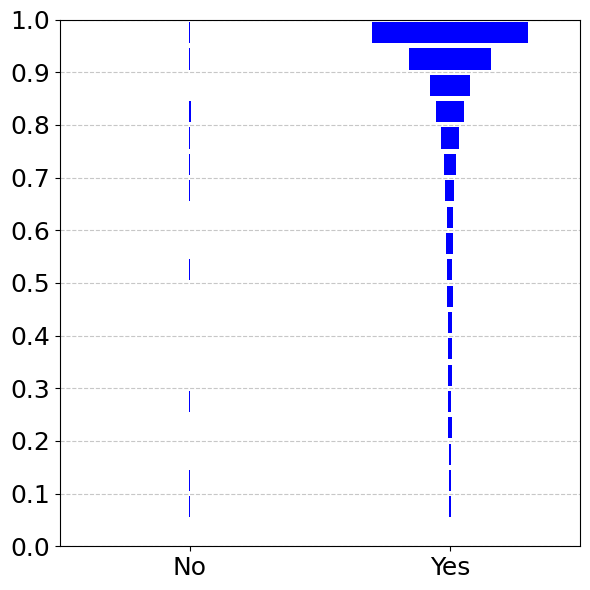

In [ ]:
# Example usage:
plot_centered_distribution(data, 'MS_LIT', 'pred')

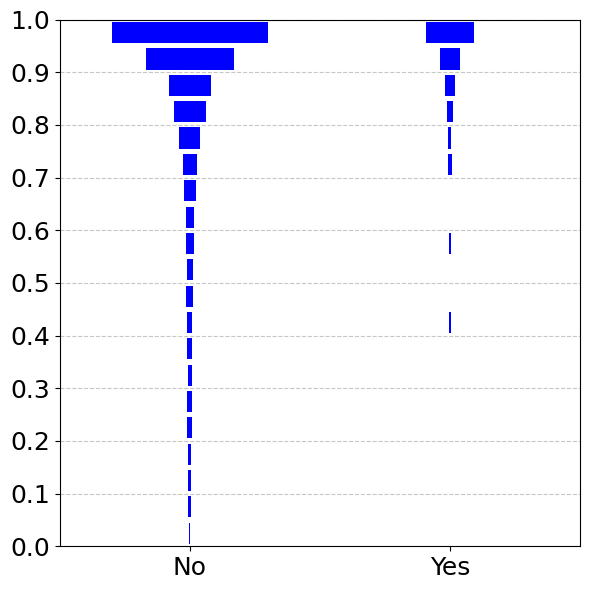

In [ ]:
plot_centered_distribution(data, 'LT_LIT', 'pred')